# MLB Pitch Identification with Machine Learning

#### This program will attempt to use a machine learning model to identify which MLB pitch is being thrown when given the pitcher, pitch velocity, vertical movement, and horizontal movement. The data used is taken from [Baseball Savant](https://baseballsavant.mlb.com/).

Note: This model is expected to have a margin of error due to the nature of baseball pitches. There are no concrete definitions for the requirements for a pitch to be considered a fastball, curveball, etc. In certain cases the differences between a slider and curveball, for example, can be so miniscule that they are essentially the same pitch and the name difference is simply a formality. This is important to consider when analyzing the accuracy of the model.

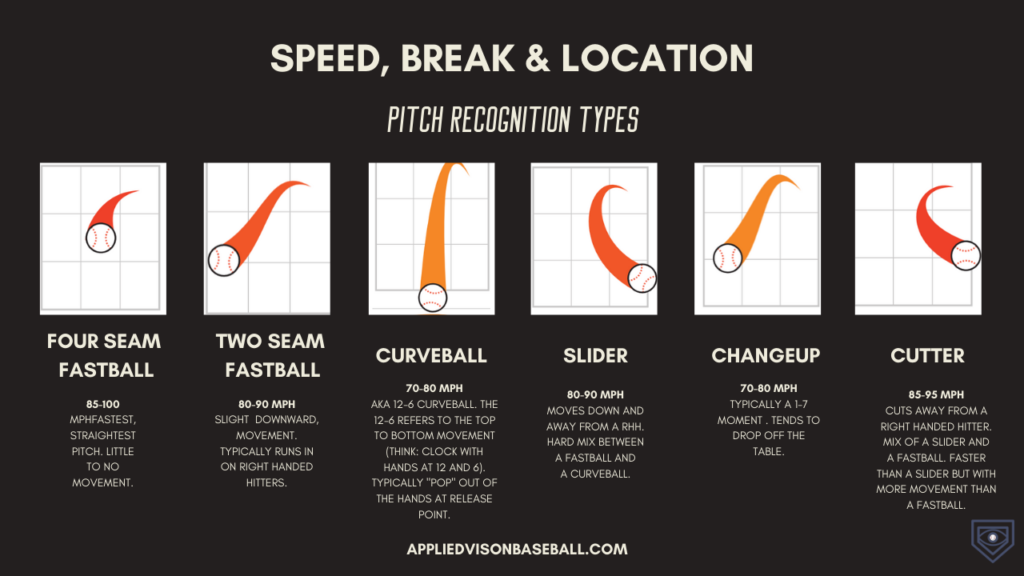

Necessary inputs

In [92]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Preparing the Data

The machine learning model I will build will consist of two separate datasets: one for training and one for testing. The dataset I will use for training will act as a sort of player profile system. As shown below, the training set will provide the model with the average movement and velocity each type of pitch thrown by every pitcher in the 2021 season.

In [93]:
df = pd.read_csv('pitchTrainSet.csv')

#combine first and last names
df['last_name'] = df[' first_name'] + ' ' + df['last_name']
df = df.rename(columns = {'last_name':'name'})
df = df.drop(columns = ' first_name')

df

name  pitcher_id  avg_speed pitch_type_name  \
0            Robbie Ray      592662       94.8        4-Seamer   
1           Sean Manaea      640455       92.1          Sinker   
2           Tyler Mahle      641816       94.0        4-Seamer   
3         Kevin Gausman      592332       94.6        4-Seamer   
4             J.A. Happ      457918       91.0        4-Seamer   
...                 ...         ...        ...             ...   
2257    Taylor Williams      592865       93.8          Sinker   
2258        Kyle Wright      657140       93.0          Sinker   
2259   Mauricio Llovera      661440       81.9          Slider   
2260        Adam Conley      543045       86.5          Slider   
2261   Reiver Sanmartin      665665       80.2          Slider   

      pitcher_break_z  pitcher_break_x  
0                13.5              8.2  
1                20.1             13.8  
2                13.9             12.1  
3                14.2             10.4  
4                16.1              7.9  
...               ...              ...  
2257             29.1             16.1  
2258             20.7             11.7  
2259             41.1             16.7  
2260             36.8              2.6  
2261             40.5              4.8  

[2262 rows x 6 columns]

For example, here are the average movement and velocities of all of Gerrit Cole's pitches from 2021.

In [94]:
df.loc[df['name'] == ' Gerrit Cole']

name  pitcher_id  avg_speed pitch_type_name  pitcher_break_z  \
7     Gerrit Cole      543037       97.7        4-Seamer             10.9   
229   Gerrit Cole      543037       88.4          Slider             34.4   
448   Gerrit Cole      543037       83.4       Curveball             51.6   
538   Gerrit Cole      543037       89.8        Changeup             24.0   

     pitcher_break_x  
7               12.0  
229              5.3  
448             10.5  
538             15.8

Using the **describe()** command will give stats for all columns of the dataframe. This can be used to see certain details about the data, such as the average pitch velocity or the standard deviation of vertical movement of pitches. 

In [95]:
df.describe()

pitcher_id    avg_speed  pitcher_break_z  pitcher_break_x
count    2262.000000  2262.000000      2262.000000      2262.000000
mean   603130.112732    87.713705        29.840141         9.156852
std     63846.459565     5.930816        13.310519         4.956264
min    425794.000000    65.800000         9.100000         0.000000
25%    571901.000000    83.500000        17.900000         5.000000
50%    613856.500000    87.600000        28.600000         8.900000
75%    656812.000000    92.900000        37.600000        13.400000
max    685503.000000   100.700000        74.300000        21.500000

For the testing sets, I will use data taken from 3 random games throughout the 2021 season in order to test how well the model can return the correct pitch. 

In [96]:
#fix pitch names to match training set
def fixPitchNames(df):
    for i in df:
        df = df.replace(to_replace = '4-Seam Fastball', value = '4-Seamer')
        df = df.replace(to_replace = 'Knuckle Curve', value = 'Curveball')
    return df
        

test1 = pd.read_csv('pitchTestSet1.csv')
test1 = fixPitchNames(test1)
test2 = pd.read_csv('pitchTestSet2.csv')
test2 = fixPitchNames(test2)
test3 = pd.read_csv('pitchTestSet3.csv')
test3 = fixPitchNames(test3)

In [97]:
test1

Pitcher Pitch Type  Pitch�Vel�(MPH)  VBreak (In.)  \
0      �Brandon Workman  Curveball             78.7            60   
1      �Brandon Workman   4-Seamer             92.3            16   
2      �Brandon Workman  Curveball             77.5            61   
3      �Brandon Workman  Curveball             76.3            62   
4      �Brandon Workman  Curveball             76.9            60   
..                  ...        ...              ...           ...   
310  �Eduardo Rodriguez   Changeup             84.1            36   
311  �Eduardo Rodriguez     Cutter             87.7            27   
312  �Eduardo Rodriguez     Cutter             87.6            28   
313  �Eduardo Rodriguez   Changeup             81.2            34   
314  �Eduardo Rodriguez   4-Seamer             91.7            18   

     HBreak (In.)  
0               5  
1               7  
2               8  
3               7  
4               5  
..            ...  
310            18  
311             2  
312             1  
313            14  
314             6  

[315 rows x 5 columns]

In [98]:
test2

Pitcher Pitch Type  Pitch�Vel�(MPH)  VBreak (In.)  HBreak (In.)
0       �Kenley Jansen     Cutter             92.7            15             7
1    �Brusdar Graterol     Sinker            101.2            21            18
2    �Brusdar Graterol     Sinker            101.7            17            18
3    �Brusdar Graterol     Sinker            100.8            17            17
4    �Brusdar Graterol     Sinker            100.8            15            17
..                 ...        ...              ...           ...           ...
286      �Ian Anderson   4-Seamer             93.5            15             8
287      �Ian Anderson   Changeup             88.2            24            11
288      �Ian Anderson   Changeup             87.5            27            12
289      �Ian Anderson   4-Seamer             93.4            14             5
290      �Ian Anderson   4-Seamer             93.5            14             8

[291 rows x 5 columns]

In [99]:
test3

Pitcher Pitch Type  Pitch�Vel�(MPH)  VBreak (In.)  HBreak (In.)
0      �Michael Fulmer     Slider             91.4            28             4
1      �Michael Fulmer   Changeup             87.7            28            17
2      �Michael Fulmer     Slider             90.3            28             2
3      �Michael Fulmer     Slider             91.1            27             6
4      �Michael Fulmer     Sinker             95.0            17            11
..                 ...        ...              ...           ...           ...
300  �Spencer Turnbull   4-Seamer             93.9            18             3
301  �Spencer Turnbull     Sinker             95.9            21            17
302  �Spencer Turnbull   4-Seamer             94.7            14             4
303  �Spencer Turnbull     Slider             85.6            37             6
304  �Spencer Turnbull   4-Seamer             94.3            15             5

[305 rows x 5 columns]

## Building the Models

The machine learning model can be designed one of two ways: a **general pitch recognition model** or a **pitcher-specific model**. 

The **general pitch recognition model** only considers the movement and velocity of the pitch, without any regards to which pitcher is throwing it. This model aims to simply give a name to a pitch based on its velocity and recorded movement, which can be useful for any situation outside of MLB games, such as high school games or scouting camps, as long as the pitch velocity and movement can be accurately recorded.

The **pitcher-specific model** considers pitch movement and velocity, as well as which pitcher is throwing it. This model takes into account the pitch arsenal of the pitcher throwing the pitch. This helps to slightly mitigate the issue of a pitcher's curveball being classified as a slider, despite the potential similarity in movement and velocity. 

### 1) General Pitch Recognition Model

For the general pitch recognition model, we will drop the name and pitcher_id columns from our training set and testing sets.

In [100]:
genTest1 = test1.drop(columns = 'Pitcher')
genTest2 = test2.drop(columns = 'Pitcher')
genTest3 = test3.drop(columns = 'Pitcher')

df_train = df.drop(columns = ['name', 'pitcher_id'])
df_train

avg_speed pitch_type_name  pitcher_break_z  pitcher_break_x
0          94.8        4-Seamer             13.5              8.2
1          92.1          Sinker             20.1             13.8
2          94.0        4-Seamer             13.9             12.1
3          94.6        4-Seamer             14.2             10.4
4          91.0        4-Seamer             16.1              7.9
...         ...             ...              ...              ...
2257       93.8          Sinker             29.1             16.1
2258       93.0          Sinker             20.7             11.7
2259       81.9          Slider             41.1             16.7
2260       86.5          Slider             36.8              2.6
2261       80.2          Slider             40.5              4.8

[2262 rows x 4 columns]

Now I will split the training data into features and labels:
- Features (X_train) : avg_speed, pitcher_break_z, pitcher_break_x
- Labels (y_train) : pitch_type_name

In [101]:
X_train = df_train.drop(columns = 'pitch_type_name')
y_train = df_train['pitch_type_name']

Next I will split the testing data into features and labels:
- Features (X_test1, X_test2, X_test3) : Pitch�Vel�(MPH), VBreak (In.), HBreak (In.)
- Labels (y_test1, y_test2, y_test3) : Pitch Type

In [121]:
X_test1 = genTest1.drop(columns = 'Pitch Type')
X_test2 = genTest2.drop(columns = 'Pitch Type')
X_test3 = genTest3.drop(columns = 'Pitch Type')

y_test1 = genTest1['Pitch Type']
y_test2 = genTest2['Pitch Type']
y_test3 = genTest3['Pitch Type']

Now it is time to create and train the model. I will use the **Random Forest Classification** model for this program, since, after previous testing, it has proven to be the most effective for this data.

In [107]:
#Create the model
model = RandomForestClassifier()

#Train the model
model.fit(X_train, y_train)

RandomForestClassifier()

Now that the model has been created, it is time to test the model with our three sets of game data and examine the accuracy of the model.

In [108]:
#test set 1
predictions = model.predict(X_test1)
score1 = accuracy_score(y_test1, predictions)
print('\nSet 1 Accuracy: ', 100*score1, '%')


#test set 2
predictions = model.predict(X_test2)
score2 = accuracy_score(y_test2, predictions)
print('\nSet 2 Accuracy: ', 100*score2, '%')


#test set 3
predictions = model.predict(X_test3)
score3 = accuracy_score(y_test3, predictions)
print('\nSet 3 Accuracy: ', 100*score3, '%')


#average accuracy
print('\nAverage Accuracy: ', 100*(score1+score2+score3)/3, '%')


Set 1 Accuracy:  82.85714285714286 %

Set 2 Accuracy:  82.4742268041237 %

Set 3 Accuracy:  88.52459016393442 %

Average Accuracy:  84.61865327506699 %


The average accuracy for the three datasets was about **84.6%**! This is a great score and shows that this model does a good job at determining which pitch is being thrown, even without knowing which pitcher is throwing the pitch. Let's see which pitches the model was confused with. 

In [109]:
#print out incorrect predictions
index = 0
count = 0
for i in y_test3:
    if i != predictions[index]:
        print(i, predictions[index])
        count = count+1
    index = index+1
    
print('\nNumber of confusions:', count)

Slider Cutter
Sinker 4-Seamer
Slider Cutter
4-Seamer Sinker
Changeup Slider
4-Seamer Cutter
4-Seamer Sinker
Cutter Slider
Cutter Slider
Changeup Slider
Changeup Slider
Changeup Slider
Changeup Slider
Slider Curveball
Slider Curveball
Slider Curveball
4-Seamer Sinker
Slider Curveball
4-Seamer Sinker
4-Seamer Cutter
Changeup Slider
4-Seamer Cutter
Changeup Slider
4-Seamer Cutter
Changeup Slider
4-Seamer Cutter
4-Seamer Cutter
Changeup Sinker
Slider Curveball
Sinker 4-Seamer
Sinker 4-Seamer
4-Seamer Cutter
Sinker 4-Seamer
Slider Curveball
Changeup Sinker

Number of confusions: 35


According to this list, the model only mixed up pitches that are similar in nature, such as 4-seamers and Cutters, and Changeups and Sliders. These pitches can have very similar movement patterns and velocities. One pitcher's slider may have the exact movement and velocity as another pitcher's curveball. All in all, this model perfectly accomplishes the goal that was set for it, which is to provide the name of the pitch being thrown only based on movement and velocity without taking into consideration the pitcher who is throwing it. 

### 2) Pitcher-Specific Model

For the pitcher-specific model, I needed to find a way to identify the pitchers without using strings, since the Random Forest Classification model does not allow for features to be strings. To solve this, I used the pitcher id numbers included in the training dataset. I also created a function to retrieve these id's and a function add them to the testing sets.

In [122]:
pitcher_id = df.drop(columns = ['avg_speed', 'pitch_type_name', 'pitcher_break_z', 'pitcher_break_x'])


#retrieve pitcher_id number
def get_pitcher_id(name):
    pi = pitcher_id.loc[pitcher_id['name'] == ' ' + name]
    return list(pi['pitcher_id'])[0]
    
    
print("Gerrit Cole's ID:", get_pitcher_id('Gerrit Cole'))

Gerrit Cole's ID: 543037


In [111]:
#add pitcher id numbers to testing sets
def add_pitcher_id(test):
    testPlayers = set(list(test['Pitcher']))
    for i in testPlayers:
        p = i[1:]
        test = test.replace(to_replace = i, value = get_pitcher_id(p))
    return test
    
specTest1 = add_pitcher_id(test1)
specTest2 = add_pitcher_id(test2)
specTest3 = add_pitcher_id(test3)

specTest1

Pitcher Pitch Type  Pitch�Vel�(MPH)  VBreak (In.)  HBreak (In.)
0     519443  Curveball             78.7            60             5
1     519443   4-Seamer             92.3            16             7
2     519443  Curveball             77.5            61             8
3     519443  Curveball             76.3            62             7
4     519443  Curveball             76.9            60             5
..       ...        ...              ...           ...           ...
310   593958   Changeup             84.1            36            18
311   593958     Cutter             87.7            27             2
312   593958     Cutter             87.6            28             1
313   593958   Changeup             81.2            34            14
314   593958   4-Seamer             91.7            18             6

[315 rows x 5 columns]

Now I'll split the train data and the new test data into features and labels:

Train:
- Features (X_train) : pitcher_id, avg_speed, pitcher_break_z, pitcher_break_x
- Labels (y_train) : pitch_type_name

Test:
- Features (X_test1, X_test2, X_test3) : Pitcher, Pitch�Vel�(MPH), VBreak (In.), HBreak (In.)
- Labels (y_test1, y_test2, y_test3) : Pitch Type

In [112]:
#training data
X_train = df.drop(columns = ['name', 'pitch_type_name'])
y_train = df['pitch_type_name']


#testing data
X_test1 = specTest1.drop(columns = 'Pitch Type')
X_test2 = specTest2.drop(columns = 'Pitch Type')
X_test3 = specTest3.drop(columns = 'Pitch Type')

y_test1 = specTest1['Pitch Type']
y_test2 = specTest2['Pitch Type']
y_test3 = specTest3['Pitch Type']

Next I'll recreate the model (still using Random Forest), train it, and check the accuracy of the model.

In [114]:
#Create the model
model = RandomForestClassifier()

#Train the model
model.fit(X_train, y_train)


#Check accuracy
#test set 1
predictions = model.predict(X_test1)
score1 = accuracy_score(y_test1, predictions)
print('\nSet 1 Accuracy: ', 100*score1, '%')


#test set 2
predictions = model.predict(X_test2)
score2 = accuracy_score(y_test2, predictions)
print('\nSet 2 Accuracy: ', 100*score2, '%')


#test set 3
predictions = model.predict(X_test3)
score3 = accuracy_score(y_test3, predictions)
print('\nSet 3 Accuracy: ', 100*score3, '%')


#average accuracy
print('\nAverage Accuracy: ', 100*(score1+score2+score3)/3, '%')


Set 1 Accuracy:  84.76190476190476 %

Set 2 Accuracy:  82.13058419243985 %

Set 3 Accuracy:  88.85245901639345 %

Average Accuracy:  85.24831599024601 %


The pitcher-specific model produced an average accuracy score of **85.2%**! As I had hypothesized, the pitcher-specific model proved to be more accurate than the general pitch recognition model, since the model is able to learn each pitcher's specific pitch arsenal and make a better prediction based off of that information.

#### Improving the Player-Specific Model

There is one last adjustment that can be made to maximize the pitcher-specific model's accuracy. 

This adjustment involves **filtering the training dataset to only include the pitchers included in the testing dataset**. This further lowers the possibility of the model predicting a pitch that the pitcher doesn't have in their arsenal.

In [115]:
#filter training sets to only include pitchers in testing set
def filter(test):
    
    global X_train, y_train
    
    df_filtered = df[df["pitcher_id"].isin(set(test['Pitcher']))]
    X_train = df_filtered.drop(columns = ['name', 'pitch_type_name'])
    y_train = df_filtered['pitch_type_name']

Now let's test out the filtering method.

In [116]:
#test set 1
filter(specTest1)
model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test1)
score1 = accuracy_score(y_test1, predictions)
print('\nSet 1 Accuracy: ', 100*score1, '%')


#test set 2
filter(specTest2)
model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test2)
score2 = accuracy_score(y_test2, predictions)
print('\nSet 2 Accuracy: ', 100*score2, '%')


#test set 3
filter(specTest3)
model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test3)
score3 = accuracy_score(y_test3, predictions)
print('\nSet 3 Accuracy: ', 100*score3, '%')


#average accuracy
print('\nAverage Accuracy: ', 100*(score1+score2+score3)/3, '%')


Set 1 Accuracy:  86.66666666666667 %

Set 2 Accuracy:  84.5360824742268 %

Set 3 Accuracy:  90.49180327868852 %

Average Accuracy:  87.231517473194 %


With the help of the filtering method I created, I was able to increase the accuracy of the pitcher-specific model to **87.2%**!

## Conclusion

Overall, I believe both models I created do a great job at identifying pitches. The general pitch recognition model can be extremely effective in identifying pitches thrown by non-MLB players, meanwhile, the pitcher-specific model does a great job at identifying pitches when the pitcher is in consideration. The filtering adjustment that I created is just one way in which the models can be improved, but I'm sure there are many other ways in which you can truly maximize their accuracies. Both of these models serve their purpose and are realistic examples of how machine learning can be utilized in collecting and analyzing baseball data.